In [273]:







# NOTE: When running this for the first time, EACH box must be ran sequentially in order to work. 


# Plotting tools 
import matplotlib.pyplot as plt 

#Numerical Tools  
import pandas as pd
import numpy as np 
import seaborn as sns
from math import sqrt

#LSTM modules 
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# Sentiment Analyzer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import os
import glob 
import warnings
warnings.simplefilter('ignore', FutureWarning)
from datetime import datetime


In [7]:
%matplotlib inline

In [8]:
# Stock to be used 
# MSFT - Microsoft 
# AAPL - Apple
# AMZN - Amazon

# Get CSV file 
files = os.listdir('FinancialDatasets/stocks')
print("Files: ", files)

print("\n")
# Stock Data for Apple 
Financial_Stock_data = os.path.join('FinancialDatasets/', 'stock_yfinance_data.csv')
Financial_Stock = pd.read_csv(Financial_Stock_data, header=0, parse_dates=True)
Financial_Stock

AAPLStock = Financial_Stock[['Date', 'Close']]
AAPLStock
# stock_sentiment['Date'] = pd.to_datetime(stock_sentiment['Date'])
# stock_sentiment['Date'] = stock_sentiment['Date'].dt.strftime('%Y-%m-%d')
# # Amazon stock 
# AMZNStock = Financial_Stock[Financial_Stock['Stock Name'] == 'AMZN']
# AMZNStock

# 

Files:  ['.ipynb_checkpoints', 'AAPL.csv', 'AMZN.csv', 'MSFT.csv']




,Date,Close
0,2021-09-30,258.493347
1,2021-10-01,258.406677
2,2021-10-04,260.510010
3,2021-10-05,260.196655
4,2021-10-06,260.916656
...,...,...
6295,2022-09-23,13.710000
6296,2022-09-26,14.370000
6297,2022-09-27,13.710000
6298,2022-09-28,13.330000


## Sentiment Analysis

In [5]:
import nltk

In [235]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# APPLE Sentiment analysis & combination of financial info

In [240]:
# Import stock sentiment 
stock_sentiment_path = os.path.join('FinancialDatasets/', 'stock_tweets.csv')
stock_sentiment = pd.read_csv(stock_sentiment_path, header=0, parse_dates=True)
stock_sentiment['Date'] = pd.to_datetime(stock_sentiment['Date'])
stock_sentiment['Date'] = stock_sentiment['Date'].dt.strftime('%Y-%m-%d')
stock_sentiment
# # Now to get stock sentiment for APPLE, MICROSOFT & AMAZON
AAPLStockSentiment = stock_sentiment[stock_sentiment['Stock Name'] == 'AAPL']
print('Apple Stock Sentiment: \n', AAPLStockSentiment.head())

# # Microsoft Sentiment 
# MSFTStockSentiment = stock_sentiment[stock_sentiment['Stock Name'] == 'MSFT'] 
# print('Microsoft Stock Sentiment: \n', MSFTStockSentiment) 

# # Amazon Stock Sentiment 
# AMZNStockSentiment = stock_sentiment[stock_sentiment['Stock Name'] == 'AMZN']
# print('Amazon Stock Sentiment: \n', AMZNStockSentiment)

Apple Stock Sentiment: 
              Date                                              Tweet  \
55958  2022-09-29  $NIO just because I'm down money doesn't mean ...   
55959  2022-09-29  After trading for 9+ years \n\nThis is how to ...   
55960  2022-09-29  Not something you see very often.  \n-2 ATR mo...   
55961  2022-09-29  $AAPL was down almost 5% today. Rare to see it...   
55962  2022-09-29  $AAPL APPLE JUST FIRED ITS HEAD OF PROCUREMENT...   

      Stock Name Company Name  
55958       AAPL   Apple Inc.  
55959       AAPL   Apple Inc.  
55960       AAPL   Apple Inc.  
55961       AAPL   Apple Inc.  
55962       AAPL   Apple Inc.  


In [242]:
import nltk 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [244]:
%%time 
# Setting pandas iteration method
pd.DataFrame.iteritems = pd.DataFrame.items
# Initialise the VADER sentiment analyser
sentiment_analyzer = SentimentIntensityAnalyzer()
# Iterate through each row in the transposed DataFrame
for indx, row in AAPLStockSentiment.T.iteritems(): 
    try: 
        # Normalise the Unicode text in the 'Tweet' column 
        sentence_i = unicodedata.normalize('NFKD', AAPLStockSentiment.loc[indx, 'Tweet'])
        # Calculate sentiment scores for the tweet using VADER
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        # Store the compound sentiment score (ranges from -1 to +1)
        AAPLStockSentiment.at[indx, 'sentiment_scores'] = sentence_sentiment['compound']
        # Store individual sentiment components (o to 1). 
        AAPLStockSentiment.at[indx, 'neg'] = sentence_sentiment['neg']
        AAPLStockSentiment.at[indx, 'neu'] = sentence_sentiment['neu']
        AAPLStockSentiment.at[indx, 'pos'] = sentence_sentiment['pos']
    except TypeError: 
        # If there's an error porcessing the tweet, print the problematic content. 
        print(AAPLStockSentiment.loc[indx, 'content'])
        print(indx)
        break

<timed exec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

CPU times: total: 2.8 s
Wall time: 3.21 s


In [245]:
score_AAPLStock = AAPLStockSentiment[["Date", "sentiment_scores"]]
score_AAPLStock = score_AAPLStock.groupby('Date').mean()
score_AAPLStock.reset_index(inplace=True)
score_AAPLStock

,Date,sentiment_scores
0,2021-09-30,0.098900
1,2021-10-01,0.291891
2,2021-10-02,0.007525
3,2021-10-03,0.834400
4,2021-10-04,0.047410
...,...,...
360,2022-09-25,0.142021
361,2022-09-26,0.289800
362,2022-09-27,0.256164
363,2022-09-28,-0.042374


In [270]:
AAPLStock = AAPLStock.groupby('Date').mean()
AAPLStock

,Close
Date,
2021-09-30,191.486836
2021-10-01,193.286088
2021-10-04,189.333359
2021-10-05,192.738946
2021-10-06,194.692045
...,...
2022-09-23,144.871999
2022-09-26,144.398001
2022-09-27,144.797200


## Merge Data and Sentiment Data

In [286]:
# Merge sentiment analysis and financial information 
comAAPLStock = pd.merge(AAPLStock, score_AAPLStock, on='Date', how='inner')
comAAPLStock = comAAPLStock.set_index('Date')
#comAAPLStock = pd.DataFrame(comAAPLStock)

# Fill NaN values with a median value
comAAPLStock = comAAPLStock.fillna(comAAPLStock.median())
comAAPLStock

,Close,sentiment_scores
Date,,
2021-09-30,191.486836,0.098900
2021-10-01,193.286088,0.291891
2021-10-04,189.333359,0.047410
2021-10-05,192.738946,0.139060
2021-10-06,194.692045,0.190330
...,...,...
2022-09-23,144.871999,0.018900
2022-09-26,144.398001,0.289800
2022-09-27,144.797200,0.256164


In [275]:
# Send to CSV file to use for Machine Learning 
comAAPLStock.to_csv('FinancialDatasets/' + "AAPLStock&Sentiment.csv")

# Calculate for Correlation 

Corelation Matrix: 

[[1.         0.06937107]
 [0.06937107 1.        ]]


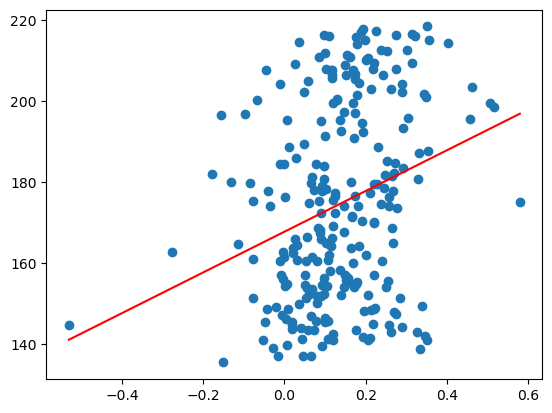

In [288]:
def calculateCorelation(sentiment_scores, stock_Prices): 

    # Calculate Returns 
    stock_returns = [(stock_prices[i] - stock_prices[i-1]) / stock_prices[i-1] for i in range(1, len(stock_prices))]
    # Prepend 0 at the beginnging of the array 
    stock_returns = np.insert(stock_returns, 0, 0)
    # Calculate the covariance matrix 
    corelation_matrix = np.corrcoef(sentiment_scores, stock_returns)

    return corelation_matrix

#Use data 
sentiment_scores = comAAPLStock['sentiment_scores'].tolist()
stock_prices = comAAPLStock['Close'].tolist()

corelation_matrix = calculateCorelation(sentiment_scores, stock_prices)

print("Corelation Matrix: \n")
print(corelation_matrix)

# Plot correlation 
plt.scatter(sentiment_scores, stock_prices)

plt.plot(np.unique(sentiment_scores), np.poly1d(np.polyfit(sentiment_scores, stock_prices, 1))
         (np.unique(sentiment_scores)), color='red')
plt.show()

In [29]:
import seaborn as sns 
scaler = MinMaxScaler(feature_range=(0, 1))

comAAPLStock[['Close']] = scaler.fit_transform(comAAPLStock[['Close']])
print("AAPL Stock Inverse", comAAPLStock)

ax = sns.heatmap(comAAPLStock.corr(), annot=True)
plt.show()

NameError: name 'comAAPLStock' is not defined

# MICROSOFT Sentiment analysis & Combination of Financial Info

In [214]:
# Get Microsoft Stock Data 
#MSFTStock
# Get Microsoft Stock Sentiment 
#MSFTStockSentiment
# Add 4 new columns [Sentiment Score, Negative, Neutural, Positive]
MSFTStockSentiment['Sentiment Score'] = ''
MSFTStockSentiment['Negative'] = ''
MSFTStockSentiment['Neutural'] = '' 
MSFTStockSentiment['Positive'] = ''

MSFTStockSentiment

C:\Users\User\AppData\Local\Temp\ipykernel_12176\436010365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MSFTStockSentiment['Sentiment Score'] = ''
C:\Users\User\AppData\Local\Temp\ipykernel_12176\436010365.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MSFTStockSentiment['Negative'] = ''
C:\Users\User\AppData\Local\Temp\ipykernel_12176\436010365.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,Date,Tweet,Stock Name,Company Name,Sentiment Score,Negative,Neutural,Positive
37422,2022-09-29,A group of lawmakers led by Sen. Elizabeth War...,MSFT,Microsoft Corporation,,,,
37423,2022-09-29,$NIO just because I'm down money doesn't mean ...,MSFT,Microsoft Corporation,,,,
37424,2022-09-29,Today’s drop in $SPX is a perfect example of w...,MSFT,Microsoft Corporation,,,,
37425,2022-09-29,Druckenmiller owned $CVNA this year \nMunger b...,MSFT,Microsoft Corporation,,,,
37426,2022-09-29,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,MSFT,Microsoft Corporation,,,,
...,...,...,...,...,...,...,...,...
41506,2021-09-30,My top 10 holdings make up 66% of my portfolio...,MSFT,Microsoft Corporation,,,,
41507,2021-09-30,Amazon $AMZN has 4X the market cap of Alibaba ...,MSFT,Microsoft Corporation,,,,
41508,2021-09-30,Returns over the last 10 Years:\n\nBitcoin $BT...,MSFT,Microsoft Corporation,,,,
41509,2021-09-30,Great snapshot of what it looks like when an i...,MSFT,Microsoft Corporation,,,,


In [216]:
%%time 
pd.DataFrame.iteritems = pd.DataFrame.items
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in MSFTStockSentiment.T.iteritems(): 
    try: 
        sentence_i = unicodedata.normalize('NFKD', MSFTStockSentiment.loc[indx, 'Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        MSFTStockSentiment.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        MSFTStockSentiment.at[indx, 'Negative'] = sentence_sentiment['neg']
        MSFTStockSentiment.at[indx, 'Neutral'] = sentence_sentiment['neu']
        MSFTStockSentiment.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError: 
        print(MSFTStockSentiment.loc[indx, 'content'])
        print(indx)
        break

<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 1.86 s
Wall time: 1.86 s


In [218]:
score_MSFTStock = MSFTStockSentiment[["Date", "sentiment_score"]]
score_MSFTStock = score_MSFTStock.groupby('Date').mean()
score_MSFTStock.reset_index(inplace=True)
score_MSFTStock.head()

,Date,sentiment_score
0,2021-09-30,0.246480
1,2021-10-01,0.359337
2,2021-10-02,-0.000700
3,2021-10-03,0.834400
4,2021-10-04,0.258650


In [221]:
# Merge sentiment analysis and financial information 
comMSFTStock = pd.merge(MSFTStock, score_MSFTStock, on="Date", how="outer")
comMSFTStock = pd.DataFrame(comMSFTStock)
# Directly remove NaN values
comMSFTStock.dropna(inplace=True)
comMSFTStock

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,sentiment_score
0,2021-09-30,285.709991,287.829987,281.619995,281.920013,278.792847,32343600.0,MSFT,0.246480
1,2021-10-01,282.119995,289.980011,281.290009,289.100006,285.893219,30086300.0,MSFT,0.359337
4,2021-10-04,287.399994,287.750000,280.250000,283.109985,279.969635,31350700.0,MSFT,0.258650
5,2021-10-05,284.049988,290.399994,284.049988,288.760010,285.556946,24993000.0,MSFT,0.045500
6,2021-10-06,285.779999,293.630005,285.510010,293.109985,289.858673,28002600.0,MSFT,0.194300
...,...,...,...,...,...,...,...,...,...
358,2022-09-23,239.539993,241.130005,235.199997,237.919998,237.251389,34176000.0,MSFT,-0.104025
361,2022-09-26,237.050003,241.449997,236.899994,237.449997,236.782700,27694200.0,MSFT,-0.068714
362,2022-09-27,239.979996,241.800003,234.500000,236.410004,235.745636,27018700.0,MSFT,-0.096700
363,2022-09-28,236.809998,242.330002,234.729996,241.070007,240.392548,29029700.0,MSFT,0.394520


In [223]:
# Send MSFTStock&Sentiment to csv file for ML
comMSFTStock.to_csv('FinancialDatasets/' + 'MSFTStock&SentimentData.csv')

In [225]:
def calculateCorelation(sentiment_scores, stock_Prices): 

    # Calculate Returns 
    stock_returns = [(stock_prices[i] - stock_prices[i-1]) / stock_prices[i-1] for i in range(1, len(stock_prices))]
    # Prepend 0 at the beginnging of the array 
    stock_returns = np.insert(stock_returns, 0, 0)
    # Calculate the covariance matrix 
    corelation_matrix = np.corrcoef(sentiment_scores, stock_returns)

    return corelation_matrix

#Use data 
sentiment_scores = comMSFTStock['sentiment_score'].tolist()
stock_prices = comMSFTStock['Adj Close'].tolist()

corelation_matrix = calculateCorelation(sentiment_scores, stock_prices)

print("Corelation Matrix: \n")
print(corelation_matrix)

Corelation Matrix: 

[[1.         0.05423345]
 [0.05423345 1.        ]]


# AMAZON Sentiment analysis & Combination of Financial Info

In [78]:
# Get Microsoft Stock Data 
#AMZNStock
# Get Microsoft Stock Sentiment 
#AMZNStockSentiment
# Add 4 new columns [Sentiment Score, Negative, Neutural, Positive]
AMZNStockSentiment['Sentiment Score'] = ''
AMZNStockSentiment['Negative'] = ''
AMZNStockSentiment['Neutural'] = '' 
AMZNStockSentiment['Positive'] = ''

AMZNStockSentiment

NameError: name 'AMZNStockSentiment' is not defined

In [229]:
%%time 
pd.DataFrame.iteritems = pd.DataFrame.items
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in AMZNStockSentiment.T.iteritems(): 
    try: 
        sentence_i = unicodedata.normalize('NFKD', AMZNStockSentiment.loc[indx, 'Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        AMZNStockSentiment.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        AMZNStockSentiment.at[indx, 'Negative'] = sentence_sentiment['neg']
        AMZNStockSentiment.at[indx, 'Neutral'] = sentence_sentiment['neu']
        AMZNStockSentiment.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError: 
        print(AMZNStockSentiment.loc[indx, 'content'])
        print(indx)
        break

<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 1.84 s
Wall time: 1.84 s


In [231]:
score_AMZNStock = AMZNStockSentiment[["Date", "sentiment_score"]]
score_AMZNStock = score_AMZNStock.groupby('Date').mean()
score_AMZNStock.reset_index(inplace=True)
score_AMZNStock.head()

,Date,sentiment_score
0,2021-09-30,0.246480
1,2021-10-01,0.359337
2,2021-10-02,-0.000700
3,2021-10-03,0.834400
4,2021-10-04,0.258650


In [66]:
# Merge sentiment analysis and financial information 
comAMZNStock = pd.merge(AMZNStock, score_AMZNStock, on="Date", how="outer")
comAMZNStock = pd.DataFrame(comAMZNStock)

# Fill NaN values with median values 
comAMZN

# Directly remove NaN values
#comAMZNStock.dropna(inplace=True)
comAMZNStock

NameError: name 'score_AMZNStock' is not defined

In [235]:
comAMZNStock.to_csv('FinancialDatasets/' + 'AMZNStock&Sentiment.csv')

In [237]:
def calculateCorelation(sentiment_scores, stock_Prices): 

    # Calculate Returns 
    stock_returns = [(stock_prices[i] - stock_prices[i-1]) / stock_prices[i-1] for i in range(1, len(stock_prices))]
    # Prepend 0 at the beginnging of the array 
    stock_returns = np.insert(stock_returns, 0, 0)
    # Calculate the covariance matrix 
    corelation_matrix = np.corrcoef(sentiment_scores, stock_returns)

    return corelation_matrix

#Use data 
sentiment_scores = comAMZNStock['sentiment_score'].tolist()
stock_prices = comAMZNStock['Adj Close'].tolist()

corelation_matrix = calculateCorelation(sentiment_scores, stock_prices)

print("Corelation Matrix: \n")
print(corelation_matrix)

Corelation Matrix: 

[[1.        0.1172535]
 [0.1172535 1.       ]]


# CONDUCT LSTM PREDICTION USING 3 DATASETS

In [31]:
# Get Apple stock and sentiment data 
AAPLStockSentimentPath = os.path.join("FinancialDatasets/", "AAPLStock&Sentiment.csv")
AAPLStockSentiment = pd.read_csv(AAPLStockSentimentPath, header=0, index_col=0, parse_dates=True)
AAPLStockSentiment
#print(AAPLStockSentiment.head())
# AAPLStockSentiment.info()
# #AAPLStockSentiment['sentiment_scores'].plot()
# #plt.show()

# # Get Microsoft Stock and Sentiment data 
MSFTSS = os.path.join("FinancialDatasets/", "MSFTStock&SentimentData.csv")
MSFTStockSentiment = pd.read_csv(MSFTSS, header=0, index_col=0, parse_dates=True)
#MSFTStockSentiment
#print("", MSFTStockSentiment.head())
#MSFTStockSentiment.info()

# # Get Amazon Stock and sentiment Data 
AMZNSS = os.path.join("FinancialDatasets/", "AMZNStock&Sentiment.csv")
AMZNStockSentiment = pd.read_csv(AMZNSS, header=0, index_col=0, parse_dates=True)
# AMZNStockSentiment
AMZNStockSentiment.head()
# AMZNStockSentiment.info()


C:\Users\User\AppData\Local\Temp\ipykernel_16920\4029825711.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MSFTStockSentiment = pd.read_csv(MSFTSS, header=0, index_col=0, parse_dates=True)
C:\Users\User\AppData\Local\Temp\ipykernel_16920\4029825711.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  AMZNStockSentiment = pd.read_csv(AMZNSS, header=0, index_col=0, parse_dates=True)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,sentiment_score
0,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000.0,AMZN,0.246480
1,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000.0,AMZN,0.359337
4,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000.0,AMZN,0.258650
5,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000.0,AMZN,0.045500
6,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000.0,AMZN,0.194300


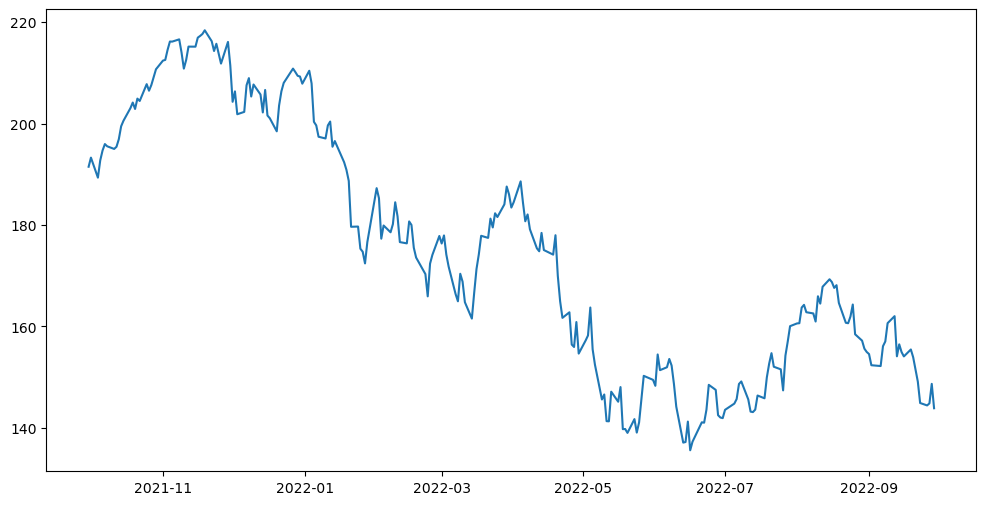

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(AAPLStockSentiment['Close'])
plt.show()

# Splitting up our Data
Changing each variable (train_data & data) to represent each stock (Apple, Amazon & Microsoft) will allow us to repeat each test 

In [466]:
# Grab Closing values of each stock & its sentiment 

### APPLE #### 
train_data = AAPLStockSentiment.iloc[:, 0:1].values
train_data_sentiment = AAPLStockSentiment.iloc[:, 1:2].values

### MICROSOFT ####
# train_data = MSFTStockSentiment.iloc[:, 4:5].values 
# train_data_sentiment = MSFTStockSentiment.iloc[:, 8:9].values 

# #### Amazon ####
# train_data = AMZNStockSentiment.iloc[:, 4:5].values
# train_data_sentiment = AMZNStockSentiment.iloc[:, 8:9].values

#train_data
#train_data_sentiment

In [468]:
train_len = math.ceil(len(train_data) * 0.8)
train_sentiment_len = math.ceil(len(train_data_sentiment) * 0.8)

In [469]:
# Scaling the values between 0 and 1 
train_close_scaled = scaler.fit_transform(train_data)
#train_close_scaled

In [472]:
train_data = train_close_scaled[0:train_len, :]
print("Train Data (Stock): ", len(train_data))

train_sentiment_data = train_data_sentiment[0:train_sentiment_len, :]
print("Train Data (Sentiment):", len(train_sentiment_data))

Train Data (Stock):  202
Train Data (Sentiment): 202


In [473]:
look_back = 3
# Feature Selection 
x_train = [] 
y_train = [] 

for i in range(look_back, len(train_data)): 
    x_train.append(train_data[i-look_back:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(x_train)

# Feature Selection for sentiment data
x_train_sent = [] 
y_train_sent = [] 

for i in range(look_back, len(train_sentiment_data)): 
    x_train_sent.append(train_sentiment_data[i-look_back:i, 0])
    y_train_sent.append(train_sentiment_data[i, 0])
x_train_sent, y_train_sent = np.array(x_train_sent), np.array(y_train_sent)

In [474]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#x_train.shape

# Reshape our Sentiment data 
x_train_sent = np.reshape(x_train_sent, (x_train_sent.shape[0], x_train_sent.shape[1], 1))
x_train_sent.shape

(199, 3, 1)

In [477]:
# Setup our LSTM model 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

# Setup our LSTM model and input our sentiment data 
model_sent = Sequential()
model_sent.add(LSTM(50, return_sequences=True, input_shape=(x_train_sent.shape[1], 1)))
model_sent.add(LSTM(50, return_sequences=False))
model_sent.add(Dense(25))
model_sent.add(Dense(1))
model_sent.summary()


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 3, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 3, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [479]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
history = model.fit(x_train, y_train, batch_size=10, epochs=200)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0020 - loss: 0.2707  
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0086 - loss: 0.0325   
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0054 - loss: 0.0135     
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0100 - loss: 0.0040   
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0092 - loss: 0.0012     
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0078 - loss: 0.0010       
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0186 - loss: 0.0011     
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0108 - loss: 0.0010         
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0048 - loss: 9.3266e-04     
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0092 - loss: 0.0010     
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0056 - loss: 9.3340e-04     
E

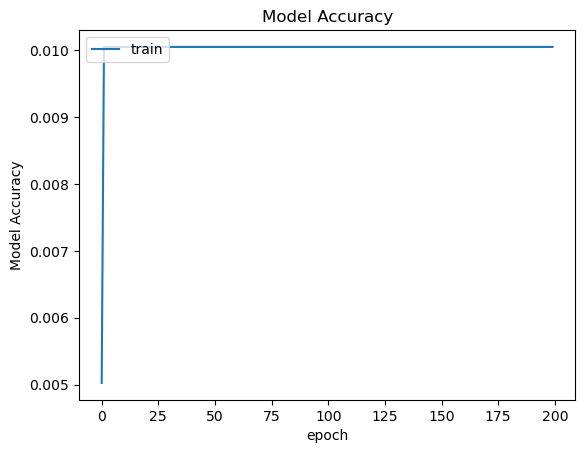

In [480]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Model Accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [481]:
model_sent.compile(optimizer='adam', loss='mean_squared_error')
history_sent = model_sent.fit(x_train_sent, y_train_sent, batch_size=32, epochs=50)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0364
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0215 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0204 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0186 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0196 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━

Reading the loss graph below we can see that loss gradually decreases as the model progresses through our data which indicates that the model is working fine and there is no need to have the accuracy metric. 

Accuracy is used for more classification tasks. It simply calculates how often predictions match labels by comparing them if the classdes are the same. 

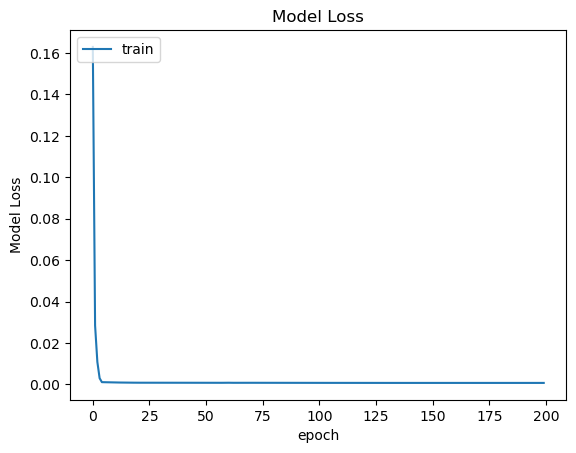

In [484]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Model Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [485]:
## NOTE: CHANGE THESE TO TEST EACH STOCK ##

data = AAPLStockSentiment.filter(['Close']).values
#data = MSFTStockSentiment.filter(['Close']).values
#data = AMZNStockSentiment.filter(['Close']).values


# Closing Price data
test_data = train_close_scaled[train_len-look_back:, :]
x_test = [] 
y_test = data[train_len:, :]

for i in range(look_back, len(test_data)): 
    x_test.append(test_data[ i - look_back:i, 0 ])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

y_test.shape, x_test.shape

((50, 1), (50, 3, 1))

In [486]:
## NOTE: CHANGE THESE TO TEST EACH STOCK ##
## Sentiment Data 
data_sent = AAPLStockSentiment.filter(['sentiment_scores']).values
#data_sent = MSFTStockSentiment.filter(['sentiment_score']).values
#data_sent = AMZNStockSentiment.filter(['sentiment_score']).values

test_data_sent = train_data_sentiment[train_sentiment_len-look_back:, :]
x_test_sent = [] 
y_test_sent = data_sent[train_sentiment_len:, :]

for i in range(look_back, len(test_data_sent)): 
    x_test_sent.append(test_data_sent[ i - look_back:i, 0 ])

x_test_sent = np.array(x_test_sent)
x_test_sent = np.reshape(x_test_sent, (x_test_sent.shape[0], x_test_sent.shape[1], 1))

y_test_sent.shape, x_test_sent.shape

((50, 1), (50, 3, 1))

In [487]:
# Make predictions 
pred = model.predict(x_test)
pred = scaler.fit_transform(pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


In [488]:
pred_sent = model_sent.predict(x_test_sent)
pred_sent = scaler.fit_transform(pred_sent)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


In [489]:
# MSE error - Stock Price 
mse = sqrt(mean_squared_error(pred, y_test)) / 10
print("MSE STOCK: ", mse)

MSE STOCK:  15.706013849853779


In [490]:
# MSE error - Sentiment Score 
mse_sent = sqrt(mean_squared_error(pred_sent, y_test_sent))
print("MSE SENTIMENT: ", mse_sent)

MSE SENTIMENT:  0.5358415836533955


In [491]:
# To get the total MSE value we can use this formula: 
# total_mse = ( (n1 * mse1) + (n2 * mse2) ) / (n1 + n2)

total_mse = ( (50 * mse) + (50 * mse_sent) ) / (50 + 50)
total_mse

8.120927716753588

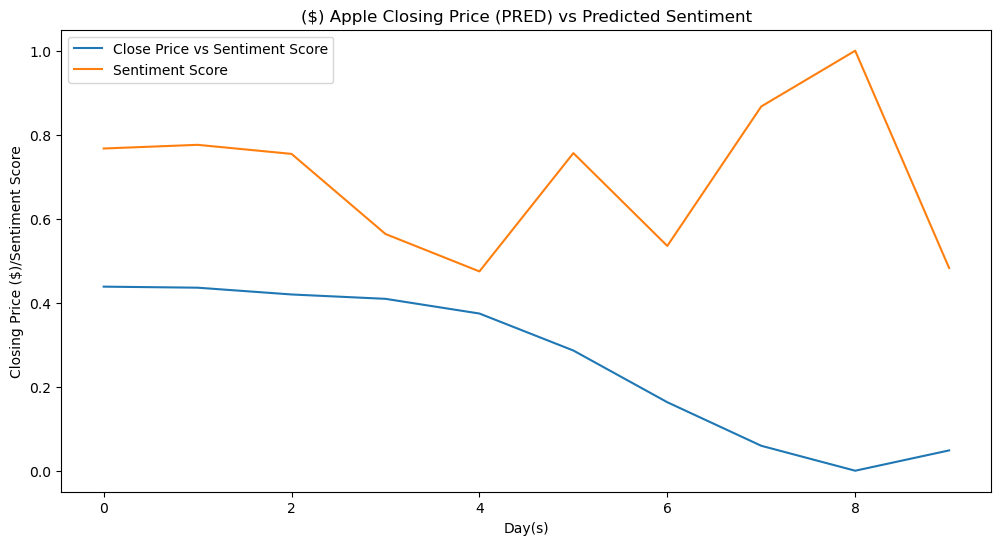

In [509]:
# 30 Day Predictions
forecasted = pred[len(pred)-10:]
forecasted_sent = pred_sent[len(pred_sent)-10:]

plt.figure(figsize=(12, 6))
plt.title('($) Apple Closing Price (PRED) vs Predicted Sentiment')
plt.plot(forecasted, label='Close Price vs Sentiment Score')
plt.plot(forecasted_sent, label='Sentiment Score')
plt.xlabel('Day(s)')
plt.ylabel('Closing Price ($)/Sentiment Score')
plt.legend()
plt.show()